In [3]:
# Importing libraries
import pandas as pd
import numpy as np
import os
import sys
import argparse
import shutil

import statsmodels.formula.api as smf
from itertools import combinations

In [4]:
# File inputs
x_input = 'data/ProCan-DepMapSanger_protein_matrix_6692_averaged.xlsx'
y_input = 'data/DrugResponse_PANCANCER_GDSC1_GDSC2_20200602.csv'

In [5]:
#One row per cell line
#DIR
x = pd.read_excel(x_input, engine='openpyxl').drop(columns=['Project_Identifier'])
c = [a.replace(';','.') for a in x.columns]
x.columns = c
x.columns

Index(['Cell_Line', 'P37108.SRP14_HUMAN', 'Q96JP5.ZFP91_HUMAN',
       'Q9Y4H2.IRS2_HUMAN', 'P36578.RL4_HUMAN', 'Q6SPF0.SAMD1_HUMAN',
       'O76031.CLPX_HUMAN', 'Q8WUQ7.CATIN_HUMAN', 'A6NIH7.U119B_HUMAN',
       'Q9BTD8.RBM42_HUMAN',
       ...
       'P33151.CADH5_HUMAN', 'Q5EBL4.RIPL1_HUMAN', 'P49715.CEBPA_HUMAN',
       'Q5TA45.INT11_HUMAN', 'O14924.RGS12_HUMAN', 'Q7Z3B1.NEGR1_HUMAN',
       'O60669.MOT2_HUMAN', 'Q13571.LAPM5_HUMAN', 'Q96JM2.ZN462_HUMAN',
       'P35558.PCKGC_HUMAN'],
      dtype='object', length=6693)

In [6]:
#DIR
y = pd.read_csv(y_input)[['drug_id','cell_line_name','ln_IC50']]
y.columns

/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Index(['drug_id', 'cell_line_name', 'ln_IC50'], dtype='object')

In [36]:
# interacting SNPs
interacting_snps = 'P02545.LMNA_HUMAN+Q5T5X7.BEND3_HUMAN'
drug_id = 1552

In [37]:
data = x.merge(y[y['drug_id']==drug_id], left_on='Cell_Line', right_on='cell_line_name')

sp=interacting_snps.split('+')
m_or = len(sp)
xy = data[sp+['ln_IC50']].dropna()#.fillna(-1)
if len(xy) <2: print('Check the NA values')
sp=interacting_snps.replace('_','').split('+')
xy.columns = [''.join([chr(int(y)+97) if y.isnumeric() else y for y in x.replace('_','').replace('.','')]) for x in xy.columns]
formula = xy.columns[-1]+' ~ '
for i in range(1,len(xy.columns)):
    formula = formula + ' + '.join(['*'.join(o) for o in list(combinations(xy.columns[:-1],i))])
    formula = formula + ' + '
formula = formula.rstrip(' + ')

#Recreating the formula
if m_or>2:
    #gathering all interactions
    fs = formula.split(' + ')
    formula = ' + '.join([a for a in fs if '*' not in a]+[a for a in fs if a.count('*')== m_or-1])
    all_interactions = [a.replace('*',':') for a in fs if '*' in a]
    final_results = pd.concat(final_results)
    subset = final_results[final_results.coef_id.apply(lambda a: a in all_interactions)].reset_index(drop=True)
    final_results = [final_results]
    if len(subset)>0:
        max_idx = subset['coef'].astype(float).abs().idxmax()
        coef_id = subset.loc[max_idx].coef_id
        formula = formula +' + '+coef_id.replace(':','*')
    else:
        pass
        #continue # bc i dont think it is a valid tree form (interaction-wise)
        #There is no sub epistasis (P>Q>O>P, tree 503, first compound)

# Standard fitting
try:
    ols = smf.ols(formula.replace('*',':'),data=xy)
    # "*" vs ":" #https://stackoverflow.com/questions/33050104/difference-between-the-interaction-and-term-for-formulas-in-statsmodels-ols
except:
    print('error in OLS')
    print('coef_id',coef_id)
    print('formula OLS',type(formula),formula)

ols.raise_on_perfect_prediction = False #preventing the perfect separation error
results = ols.fit(disp=False, maxiter=1000) #mehtod prevents singular matrix

#If nan means no convergence bc singular matrix
#adding regularization
#if 'nan' == pd.DataFrame(nan)['z'].astype(str).iloc[2].strip():
#    try:
#        print('Not the standard fitting')
#        results = ols.fit_regularized(method='l1', disp=False, maxiter=1000, alpha=0.3) #mehtod prevents singular matrix    
#    except:
#        print('Crashed')


results.summary()

/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1749: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/opt/homebrew/anaconda3/envs/vs05/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 lnICfa   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 25 Jan 2023   Prob (F-statistic):                nan
Time:                        16:00:05   Log-Likelihood:                 115.89
No. Observations:                   4   AIC:                            -223.8
Df Residuals:                       0   BIC:                            -226.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                          507.7407        inf          0        nan         nan         nan
PacfefLMNAHUMAN                    -96.6069        inf         -0        nan         nan         nan
QfTfXhBENDdHUMAN                  -317.6930        inf         -0        nan         nan         nan
PacfefLMNAHUMAN:QfTfXhBENDdHUMAN    60.5158        inf          0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   1.420
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.319
Skew:                           0.487   Prob(JB):                        0.853
Kurtosis:                       2.017   Cond. No.                     1.22e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
print('Number of samples:',len(xy))

Number of samples: 4


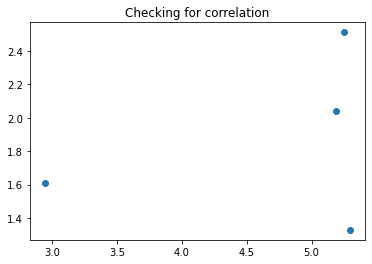

In [39]:
import numpy as np
import matplotlib.pyplot as plt

plt.scatter(xy[xy.columns[0]], xy[xy.columns[1]])
plt.title("Checking for correlation")
plt.show()

In [ ]:
# Add deaper analysis here (if needed)